In [1]:
%matplotlib notebook

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes
import qcodes as qc
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import new_experiment

In [2]:
# %qtconsole

# Custom imports

In [3]:
from pytopo.awg_sequencing import broadbean as bbtools; reload(bbtools)
from pytopo.awg_sequencing import awg_tools; reload(awg_tools)
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar import awg_sequences; reload(awg_sequences)
from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

In [4]:
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.sweep.base import Nest, Chain 
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

from qcodes.math.field_vector import FieldVector
from pytopo.field_optimization.movement import FieldOptimizationProblem 
from pytopo.cQED import softwarespec as ss

# Measurement functions

## Qubit measurements

In [5]:
from lmfit.models import LorentzianModel
def fit_lorentzian(x,y):
    mod = LorentzianModel()

    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    return out

# xtest=np.arange(-100,100.,1)
# ytest=1.0/np.pi*(2.0/((xtest-3)**2+2.0**2))

# plt.plot(xtest,ytest,'.')
# output=fit_lorentzian(xtest,ytest)
# output.plot_fit()
# output.best_values['sigma']
# output.best_values['center']

def get_resonator_spec_and_fit(frequencies):
    mag, phase = ss.get_soft_sweep_trace()
    out = fit_lorentzian(frequencies, mag**2)
    return mag, phase, out

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('signal_magnitude', 'V', 'array'), ('signal_phase', 'deg', 'array'), ('peak_frq', 'Hz', 'array')]
)
def measure_qubit_spec_optimize_resonator(resonator_frequencies, resonator_src, 
                                          qubit_frequencies, qubit_src, integration_time=10e-3,
                                          *arg, **kw):
    """
    Use the softspec controller to measure a software-controlled spectrum.
    time_bin is the time per buffer, integration_time sets how many buffers we'll average per 
    frequency point.
    """    
    ctl = ss.setup_soft_sweep(resonator_frequencies, resonator_src.frequency, 
                           integration_time=integration_time, setup_awg=False, **kw)
    
    _, _, fitout = get_resonator_spec_and_fit(resonator_frequencies)
    peak_frequency = fitout.best_values['center']
    resonator_src.frequency(peak_frequency)
    print(f'Found resonator peak frequency: {peak_frequency:1.5e}')
    
    ctl = ss.setup_soft_sweep(qubit_frequencies, qubit_src.frequency, 
                           integration_time=integration_time, setup_awg=False, **kw)    
    mag, phase = ss.get_soft_sweep_trace(ctl)
       
    
    return (qubit_frequencies.reshape(-1), 
            np.vstack((mag.reshape(-1), phase.reshape(-1), np.ones(qubit_frequencies.size) * peak_frequency)))

## Get resonator trace and plot

In [6]:
from functools import partial
from qcodes.math.field_vector import FieldVector

def get_resonator_freq(): #helper function to pass variables into resonator spec
    global xvals
    return get_resonator_spec_and_fit(xvals)

def get_resonator_FWHM(): #helper function to pass variables into resonator spec
    global xvals
    _,_,fitout=get_resonator_spec_and_fit(xvals)
    return 2*fitout.params['sigma'].value

def measure_and_plot_resonator(ax, line): #plots the trace
    liney, phasey, fitout = get_resonator_freq()
    time.sleep(0.5)
    
    line.set_ydata(liney)
    ax.relim()
    ax.autoscale_view(True, True, True)
    ax.get_figure().canvas.draw()
    
    return fitout.params['center'].value

# Init

## Configurables

In [7]:
SAMPLE = "20170926_20nm_37_d2_CD20181017"

## Initialize instruments

In [8]:
%run -i D:/OneDrive/Setups/LK1/LK1_code/Code/LK1/LK1/init_station_cqed.py

Connected to: TEKTRONIX AWG5014C (serial:B010125, firmware:SCPI:99.0 FW:4.1.1.5) in 0.09s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110435, firmware:3.1.19.15-3.50.124.67) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110869, firmware:3.1.19.26-3.50.124.73) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110430, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Agilent Technologies E8267D (serial:US50350091, firmware:C.06.10) in 0.08s
Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:124050266, firmware:2.6.04.000) in 0.07s


In [9]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, 'ivvi', address='ASRL1', numdacs=16, force_new_instance=True)
add2station(station, ivvi)

numdacs = int(ivvi._numdacs)
for i in range(1, numdacs+1):
    station.ivvi.parameters['dac{}'.format(i)].set_step(10)
    station.ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

Initialized IVVI-rack in 0.03s


d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument\parameter.py:585: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument\parameter.py:597: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [10]:
with station.alazar.syncing():
    station.alazar.channel_range1(0.4)
    station.alazar.channel_range2(0.4)
    station.alazar.sample_rate(int(2.0e8))
    
station.hetsrc.RF.power(-70)
station.hetsrc.IF(25e6)
station.hetsrc.frequency(5.5e9)

#station.TWPA.power(8.5)
#station.TWPA.frequency(8.0123e9)

station.LO.frequency(), station.RF.frequency(), station.TWPA.frequency()

(5475000000.0, 5500000000.0, 7970000000.0)

## Setting up Alazar acquisition controllers

In [11]:
# regular post-measurement IQ demod controller
post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   allocate_samples=5e8, 
                                   force_new_instance=True)
add2station(station, post_iq_acq)
post_iq_acq.demod_frq(2.5e7)

# controller that can step frequencies during acquisition.
softsweep_ctl = instools.create_inst(ss.SoftSweepCtl,
                                     'softsweep_ctl', 'alazar',
                                     allocate_samples=5e8, 
                                     force_new_instance=True)
add2station(station, softsweep_ctl)
softsweep_ctl.demod_frq(2.5e7)

Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)


## Essential AWG Sequences

In [12]:
from pytopo.rf.alazar.awg_sequences import TriggerSequence

TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', 'ro_trigger'],
    2 : [None, 'qb_trigger', None],
}
TriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

# Setup and expt. specific tools

In [13]:
dac_cutter = station.ivvi.dac1
dac_leftplunger = station.ivvi.dac11
dac_rightplunger = station.ivvi.dac13
dac_leftplunger_fine = station.ivvi.dac12
dac_rightplunger_fine = station.ivvi.dac14

@setter(('plungers', 'mV'),)
def set_plungers(val):
    """
    Set both plungers (left and right) to val (in mV).
    """
    dac_leftplunger(val)
    dac_rightplunger(val)
    return val

In [14]:
@setter(('magnet_r', 'T'),) ##could be combined into a single one, but we generally want to sweep them individually and not touch the others
def set_magnet_r(val):
    """
    Set magnet r
    """
    station.mgnt.r_target(val)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_phi', 'degrees'),)
def set_magnet_phi(val):
    """
    Set magnet phi
    """
    station.mgnt.phi_target(val)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_theta', 'degrees'),)
def set_magnet_theta(val):
    """
    Set magnet theta
    """
    station.mgnt.theta_target(val)
    station.mgnt.ramp(mode='safe')
    return val

# EVERYTHING ABOVE HERE SHOULD BE RUN FOR INITIALIZATION

# Resonator spec

In [14]:
ss.setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
# station.TWPA.on() #we don't have a BNC T at the moment, we can remove this once we split the marker for the cavity
so = sweep(station.hetsrc.frequency, np.arange(5.30e9, 5.33e9, 1e6))(
    measure(ss.get_single_averaged_IQpoint_chanA),
)

result = do_experiment(f"resonator_spec/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

Starting experimental run with id: 325


## Standard resonator spec

In [173]:
dac_cutter(1010)

In [222]:
station = qcodes.Station.default #standard resonator spec
station.hetsrc.RF.power(-55)


ctl = ss.setup_soft_sweep(np.linspace(5.285e9, 5.32e9, 101), station.hetsrc.frequency, 
                          time_bin=0.2e-3, integration_time=100e-3)
#ctl.settling_time = 100e-3
station.alazar.allocated_buffers(10)
so = ss.measure_soft_time_avg_spec(np.linspace(5.29e9, 5.32e9, 101), station.hetsrc, 
                                   setup=False)


result = do_experiment(f'resonator_spec/{SAMPLE}', so, live_plot=True)


Starting experimental run with id: 425


<IPython.core.display.Javascript object>


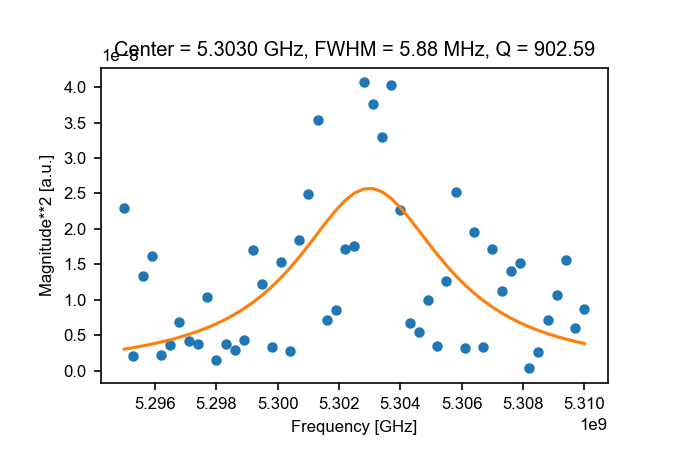

Text(0.5,1,'Center = 5.3030 GHz, FWHM = 5.88 MHz, Q = 902.59')

In [249]:
station.hetsrc.RF.power(-60)
hetfreqs = np.linspace(5.29e9, 5.305e9, 101)
#station.TWPA.on()
ctl = ss.setup_soft_sweep(hetfreqs, station.hetsrc.frequency, integration_time=100e-3)
testout = get_resonator_spec_and_fit(hetfreqs)
#station.TWPA.off()

plt.figure()
plt.plot(hetfreqs,testout[0]**2,'o')
plt.plot(hetfreqs,testout[2].best_fit)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude**2 [a.u.]')
plt.title('Center = %.4f GHz, FWHM = %.2f MHz, Q = %.2f' % (testout[2].params['center'].value*1e-9, 2*testout[2].params['sigma'].value*1e-6, testout[2].params['center'].value/(2*testout[2].params['sigma'].value)))

<IPython.core.display.Javascript object>


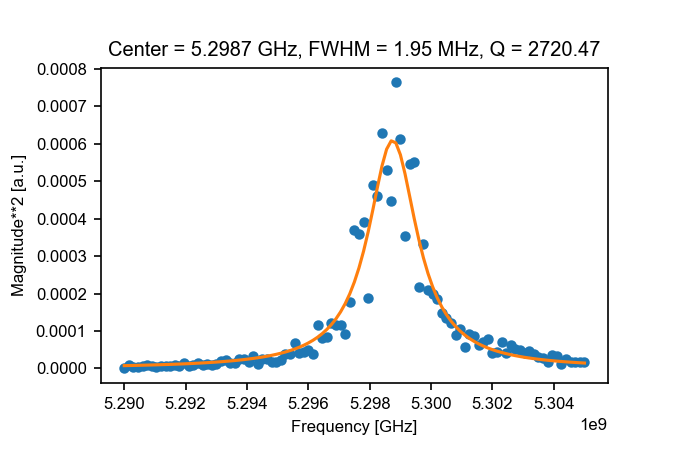

Text(0.5,1,'Center = 5.2987 GHz, FWHM = 1.95 MHz, Q = 2720.47')

In [201]:
station.hetsrc.RF.power(-30)
hetfreqs = np.linspace(5.29e9, 5.305e9, 101)
#station.TWPA.on()
ctl = ss.setup_soft_sweep(hetfreqs, station.hetsrc.frequency, integration_time=30e-3)
testout = get_resonator_spec_and_fit(hetfreqs)
#station.TWPA.off()

plt.figure()
plt.plot(hetfreqs,testout[0]**2,'o')
plt.plot(hetfreqs,testout[2].best_fit)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude**2 [a.u.]')
plt.title('Center = %.4f GHz, FWHM = %.2f MHz, Q = %.2f' % (testout[2].params['center'].value*1e-9, 2*testout[2].params['sigma'].value*1e-6, testout[2].params['center'].value/(2*testout[2].params['sigma'].value)))

## Live-monitor of resonator spec

In [ ]:
fvals = np.linspace(5.29e9, 5.33e9, 51)
ctl = ss.setup_soft_sweep(fvals, station.hetsrc.frequency, integration_time=30e-3)

def monitor_resonator_spec(ax, fvals, data_line=None):
    mag, phase, fitout = get_resonator_spec_and_fit(fvals)
    
    if data_line is None:
        data_line = ax.plot(fvals, mag**2)[0]
    else:
        data_line.set_ydata(mag**2)
    
    ax.relim()
    ax.autoscale_view(True, True, True)
    ax.get_figure().canvas.draw()
    
    return data_line
    

fig, ax = plt.subplots(1,1)

data_line = None
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')

for i in range(10):
    data_line = monitor_resonator_spec(ax, fvals, data_line=data_line)

## Resonator spec vs power

In [159]:
station = qcodes.Station.default #resonator spec vs power
spec_frequencies=np.linspace(5.295e9, 5.31e9, 61)
spec_src=station.hetsrc.frequency
spec_powers=np.linspace(-70,-30,17)[::-1]

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src)

#station.TWPA.on()
station.TWPA.off()
so = sweep(station.hetsrc.RF.power,spec_powers)(
    ss.measure_soft_time_avg_spec(spec_frequencies, station.hetsrc, integration_time=100e-3, setup=False))

result = do_experiment(f'resonator_specvspower/{SAMPLE}', so, live_plot=True)


Starting experimental run with id: 393


<IPython.core.display.Javascript object>


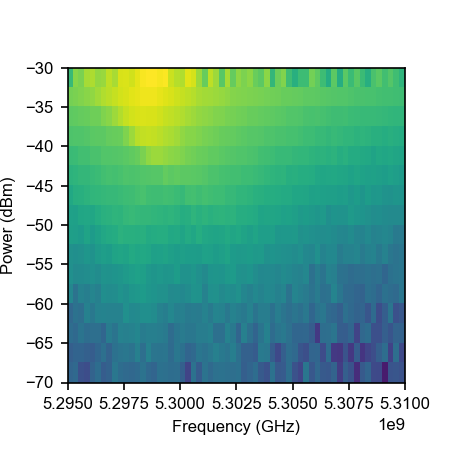

Text(0,0.5,'Power (dBm)')

In [169]:
from matplotlib.colors import LogNorm
data = qc.dataset.data_export.load_by_id(393)
freqs = data.get_data('frequency')
powers = data.get_data('RF_power')
signal = data.get_data('signal_magnitude')

x = freqs[0][0]
y = np.array(powers)[:,0].T
X,Y = np.meshgrid(x,y)
Z = np.array(signal)[:,0,:]

Znorm = np.copy(Z)
for i in range(len(X[:,0])):
    Znorm[i,:] = Znorm[i,:]/np.mean(Znorm[i,-15:-1])

plt.figure(figsize=(3, 3))
plt.pcolor(X,Y,Z,cmap='viridis', norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dBm)')
#plt.axis([x.min(),x.max(),y.min(), y.max()])



# TWPA tuning

In [ ]:
np.linspace(4.0, 8, 41)[::-1]

In [ ]:
station.TWPA.power(6.75)
station.TWPA.frequency(8.004e9)

In [ ]:
# station.hetsrc.RF.power(-60)
# so = sweep(station.TWPA.power, np.arange(9, 11, 0.1))(
#     softspec(np.linspace(5.3e9, 5.326e9, 27), station.hetsrc, navgs=10, setup_awg=False)
# )

# result = do_experiment(f'TWPA_resonator_spec/{SAMPLE}', so, live_plot=True)

In [ ]:
def get_snr_from_max(trace, background_range=(0, 30)):
    idx0, idx1 = background_range
    S = np.abs(trace).max()
    N = np.abs(np.std(trace[idx0:idx1]))
    return S, N

@getter(('SNR', ''))
def SNR():
    mag, phase = ss.get_soft_sweep_trace()
    trace = mag * np.exp(-1j*phase)
    s, n = get_snr_from_max(trace)
    return s/n

spec_frequencies = np.linspace(5.27e9, 5.31e9, 101)
spec_src = station.hetsrc
integration_time = 20e-3

#pump_amps = np.linspace(8.0, 11, 32)
pump_amps = np.linspace(4.0, 8, 41)[::-1]
#pump_frqs = np.linspace(7.99e9, 8.02e9, 31)
pump_frqs = np.arange(7.91e9, 8.05e9, 1e6)

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=integration_time)

station.TWPA.on()
so = sweep(station.TWPA.power, pump_amps)(
    sweep(station.TWPA.frequency, pump_frqs)(
#         measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=integration_time, setup=False),
        measure(SNR),
    )
)

result = do_experiment(f'tune_TWPA_resonator_spec/{SAMPLE}', so, live_plot=True)
station.TWPA.off() #the TWPA power seems to warm up the fridge so let's turn it off when we are not measuring

In [ ]:
station.RF.power()

# Resonator vs Gate Response

## Measure at a single frequency

### Vs cutter

In [155]:
dac_cutter(998)

In [ ]:
#setup_single_averaged_IQpoint(0.1e-3, 10e-3, setup_awg=True)

cur_cutter = dac_cutter()
#station.hetsrc.frequency(5.31347e9)
#station.TWPA.on() #we don't have a BNC T at the moment, we can remove this once we split the marker for the cavity
so = sweep(dac_cutter, np.arange(cur_cutter, 1800, 1))(
    measure(ss.get_single_averaged_IQpoint_chanA),
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

In [154]:
station.hetsrc.frequency(5.2983e9)
station.hetsrc.RF.power(-70)

cur_cutter = dac_cutter()

so = ss.measure_soft_gate_sweep(
    np.arange(2000., 0., -1.), dac_cutter,
    integration_time=30e-3, setup=True,
)


result = do_experiment(f"soft_sweep_gate/{SAMPLE}", so, live_plot=True)

Starting experimental run with id: 389


### Vs plungers

In [ ]:
station.hetsrc.frequency(5.305e9)
cur_plunger = dac_leftplunger()

ss.setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
so = sweep(set_plungers, np.arange(cur_plunger,-400,1))(
    measure(ss.get_single_averaged_IQpoint_chanA),
)

#station.TWPA.on()
result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
#station.TWPA.off()

In [ ]:
# station.hetsrc.frequency(5.305e9)
# station.hetsrc.RF.power(-70)

# cur_plunger = dac_leftplunger()

# so = ss.measure_soft_gate_sweep(
#     np.arange(cur_plunger, cur_plunger+5, 0.1), dac_cutter,
#     integration_time=10e-3, setup=True,
# )

# station.TWPA.on()
# result = do_experiment(f"soft_sweep_gate/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

### Fixed frequency scans (view each point)

In [ ]:
station.TWPA.frequency()

In [ ]:
%%time
#Fixed frequency scan if you want to see each point individually

station.hetsrc.frequency(5.31347e9+4e6)
cur_plunger = dac_leftplunger()
cur_cutter = dac_cutter()
cutter_vals = np.arange(300,1500.,5)
plunger_vals = np.arange(-300,100.,10)


setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
so = sweep(dac_cutter, cutter_vals)(sweep(set_plungers, plunger_vals)(
    measure(get_single_averaged_IQpoint_chanA),
))

station.TWPA.on()
result = do_experiment(f"fixed_frequency/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

### Fixed frequency scan (only see 1d, faster)

In [226]:
dac_leftplunger()

-1405.020218204013

In [223]:
%%time
#Fast Fixed frequency scan if not seeing each 1d line is ok with you
station.hetsrc.RF.power(-65)
station.hetsrc.frequency(5.2983e9+4e6)
cur_plunger = dac_leftplunger()
cur_cutter = dac_cutter()
cutter_vals = np.arange(400,2000.,2.5)[::-1]
plunger_vals = np.arange(-2000,-1400.,5)


ss.setup_soft_sweep(plunger_vals, set_plungers, time_bin=0.2e-3, integration_time=60e-3, setup_awg=True, ctl=None)
so = sweep(dac_cutter, cutter_vals)(ss.measure_soft_gate_sweep(
    plunger_vals, set_plungers, setup=False))

result = do_experiment(f"fixed_frequency/{SAMPLE}", so, live_plot=True)


Starting experimental run with id: 426
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout dur

Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)
Timeout during sending!)


## Take full resonator scan vs gate

### Vs cutter

In [224]:
cur_cutter = dac_cutter()
station.hetsrc.RF.power(-60)
spec_frequencies=np.arange(5.295e9, 5.31e9, 0.2e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=100e-3)

so = sweep(dac_cutter, np.arange(1600, 1400, -0.5))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, setup=False)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)

Starting experimental run with id: 427


KeyboardInterrupt: 

### Vs plungers

In [ ]:
cur_plunger = dac_leftplunger()
station.hetsrc.RF.power(-70)
spec_frequencies=np.linspace(5.305e9, 5.32e9, 151)
spec_src=station.hetsrc

ctl = ss.setup_soft_time_avg_spec(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(set_plungers, np.arange(cur_plunger,-250.0,-1))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

In [204]:
cur_plunger = dac_leftplunger_fine()
station.hetsrc.RF.power(-55)
spec_frequencies=np.arange(5.292e9, 5.305e9, 0.1e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, station.hetsrc.frequency, 
                          time_bin=0.2e-3, integration_time=100e-3)


so = sweep(dac_leftplunger_fine, np.arange(cur_plunger,cur_plunger+60,2))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, setup=False)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)



Starting experimental run with id: 411


KeyboardInterrupt: 

# Qubit spec

## Spec vs power

In [233]:
station = qcodes.Station.default #spec at one power
station.hetsrc.RF.power(-45)
station.hetsrc.frequency(5.3046e9)
station.qubsrc.power(-5)
qubit_frequencies = np.arange(4.2e9, 4.8e9, 10e6)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=100e-3)


spec_src.output_rf('ON')
so = ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False)

result = do_experiment(f'qubit_spec/{SAMPLE}', so, live_plot=True)


Starting experimental run with id: 431


In [244]:
for integrationtime in np.array([300e-3,200e-3,100e-3]):
    for RF_power in np.array([-45,-50,-55,-60]):
        station = qcodes.Station.default ##spec vs S1 power
        station.hetsrc.RF.power(RF_power)
        station.hetsrc.frequency(5.3046e9)
        station.qubsrc.power(-15)
        qubit_frequencies = np.arange(4.3e9, 4.9e9, 14e6)
        qubit_powers = np.linspace(-15,-5,3)
        spec_src=station.qubsrc

        ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=integrationtime)


        spec_src.output_rf('ON')
        so = sweep(station.qubsrc.power,qubit_powers)(
            ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False))

        result = do_experiment(f'qubit_spec_vs_power/{SAMPLE}', so, live_plot=True)


Starting experimental run with id: 446
Starting experimental run with id: 447
Starting experimental run with id: 448
Starting experimental run with id: 449
Starting experimental run with id: 450
Starting experimental run with id: 451
Starting experimental run with id: 452
Starting experimental run with id: 453
Starting experimental run with id: 454
Starting experimental run with id: 455
Starting experimental run with id: 456
Starting experimental run with id: 457


In [232]:
station = qcodes.Station.default ##spec vs RF power
station.hetsrc.RF.power(-60)
station.hetsrc.frequency(5.3046e9)
station.qubsrc.power(-5)
qubit_frequencies = np.arange(4.4e9, 4.9e9, 10e6)
RF_powers = np.linspace(-70,-40,5)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=100e-3)


spec_src.output_rf('ON')
so = sweep(station.hetsrc.RF.power,RF_powers)(
    ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, integration_time=100e-3, setup=False))

result = do_experiment(f'qubit_spec_vs_power/{SAMPLE}', so, live_plot=True)


Starting experimental run with id: 430


## Spec vs gates

### Coarse scans (requiring resonator frequency change)

In [214]:
station = qcodes.Station.default
station.hetsrc.RF.power(-60)
station.qubsrc.power(-10)
het_freqs = np.arange(5.295e9,5.304e9,0.5e6)
qub_freqs = np.arange(3.2e9, 4.8e9, 8e6)
cur_cutter = dac_cutter()
cutter_voltages = np.arange(cur_cutter-3, cur_cutter+3, 0.2)

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=100e-3)
so = sweep(dac_cutter, cutter_voltages)(
    ss.measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, station.qubsrc, integration_time=100e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

Starting experimental run with id: 419
Found resonator peak frequency: 5.29868e+09
Found resonator peak frequency: 5.29894e+09
Found resonator peak frequency: 5.29879e+09
Found resonator peak frequency: 5.29868e+09
Found resonator peak frequency: 5.29870e+09
Found resonator peak frequency: 5.29854e+09
Found resonator peak frequency: 5.29852e+09
Found resonator peak frequency: 5.29867e+09


KeyboardInterrupt: 

In [213]:
reload(ss)

<module 'pytopo.cQED.softwarespec' from 'd:\\onedrive\\setups\\lk1\\lk1_code\\code\\pytopo\\pytopo\\cQED\\softwarespec.py'>

In [ ]:
station = qcodes.Station.default
station.hetsrc.RF.power(-60)
station.qubsrc.power(-10)
het_freqs = np.arange(5.295e9,5.304e9,0.5e6)
qub_freqs = np.arange(6.2e9, 8.0e9, 8e6)
cur_plunger = dac_leftplunger()
plunger_voltages = np.arange(cur_plunger, cur_plunger+160, 0.2)

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
so = sweep(set_plungers, plunger_voltages)(
    measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, station.qubsrc, integration_time=30e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

### Fine scans (resonator does not change)

In [241]:
station = qcodes.Station.default #charge dispersions
station.hetsrc.RF.power(-50)
station.hetsrc.frequency(5.3046e9)
station.qubsrc.power(-5)
qubit_frequencies = np.arange(3.8e9, 4.9e9, 10e6)
# cur_plunger = dac_leftplunger_fine()
plunger_voltages = np.arange(0., 60., 2)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=100e-3)

station.TWPA.off()
spec_src.output_rf('ON')
so = sweep(dac_leftplunger_fine, plunger_voltages)(
    ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False))

result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)
#station.TWPA.off()

Starting experimental run with id: 441


In [236]:
station = qcodes.Station.default #charge dispersions with phase information
station.hetsrc.RF.power(-50)
station.hetsrc.frequency(5.3046e9)
station.qubsrc.power(-5)
qubit_frequencies = np.arange(4.0e9, 4.9e9, 10e6)
cur_plunger = dac_leftplunger_fine()
plunger_voltages = np.arange(0., 60., 2)
spec_src=station.qubsrc

ctl = ss.setup_single_averaged_IQpoint(0.2e-3, 100e-3, setup_awg=True)


spec_src.output_rf('ON')
so = sweep(dac_leftplunger_fine, plunger_voltages)(sweep(station.qubsrc.frequency, qubit_frequencies)(
    measure(ss.get_single_averaged_IQpoint_chanA),
))
    
result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)

Starting experimental run with id: 439


KeyboardInterrupt: 

In [ ]:
res_powers = np.arange(-70,-45,5)
spec_powers = np.arange(-30,-15,5)

for res_power in res_powers:
    for spec_power in spec_powers:
        station = qcodes.Station.default ##spec vs cutter
        station.hetsrc.RF.power(res_power)
        station.hetsrc.frequency(5.30e9)
        station.qubsrc.power(spec_power)
        qubit_frequencies = np.arange(6.0e9, 7.2e9, 10e6)
        cur_plunger = dac_leftplunger_fine()
        plunger_voltages = np.arange(cur_plunger, cur_plunger+60, 2)
        spec_src=station.qubsrc

        ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=30e-3)

        station.TWPA.off()
        spec_src.output_rf('ON')
        so = sweep(dac_leftplunger_fine, plunger_voltages)(
            ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False))

        result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)
        #station.TWPA.off()

In [15]:
station.ivvi.set_dacs_zero()

# Magnetic Field Sweeps

## TESTING UNDER DEVELOPMENT DO NOT USE UNLESS YOU ARE SURE

In [16]:
print('Measured field = ' + station.mgnt.field_measured().repr_spherical())
#print('Measured field = ' + station.mgnt.field_measured().repr_cartesian())
print('Target field = ' + station.mgnt.field_target().repr_spherical())
#print('Target field = ' + station.mgnt.field_target().repr_cartesian())

Measured field = FieldVector(r=1.4988287760781749, phi=-172.98349825527708, theta=0.7510733040964382)
Target field = FieldVector(r=1.4988287760781749, phi=-172.98349825527708, theta=0.7510733040964382)


### Get resonator trace and plot

In [ ]:



#ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
#testout = get_resonator_spec_and_fit(het_freqs)
#testout.params['center'].value, testout.params['center'].stderr


## Manual Magnet Sweeps

In [25]:
station.mgnt.ramp()

KeyboardInterrupt: 

In [19]:
#station.mgnt.field_ramp_rate(FieldVector(x=1e-3, y=1e-3, z=1e-3)) ##sweep r


cur_r = station.mgnt.r_measured()
station.hetsrc.RF.power(-30)
spec_frequencies=np.arange(5.28e9, 5.316e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)


so = sweep(set_magnet_r, np.arange(cur_r,0.1e-3,-10e-3))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src.frequency, setup=False)
)

result = do_experiment(f"resonator_magnet_r/{SAMPLE}", so, live_plot=True)




Starting experimental run with id: 470


In [142]:
if station.mgnt.r_measured() > 0.015:
    cur_theta = station.mgnt.theta_measured() ##makes sure you don't get jumps if you are not exactly @ setpoint
else:
    cur_theta = station.mgnt.theta_target() #makes sure theta doesn't change sign when phi is not well defined

station.hetsrc.RF.power(-30)
spec_frequencies=np.arange(5.2850e9, 5.310e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)


so = sweep(set_magnet_theta, np.arange(cur_theta,cur_theta-0.01, -0.0005))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src.frequency, setup=False)
)

result = do_experiment(f"resonator_magnet_theta/{SAMPLE}", so, live_plot=True)



Starting experimental run with id: 386


KeyboardInterrupt: 

In [88]:
if station.mgnt.r_measured() > 0.015:
    cur_phi = station.mgnt.phi_measured() ##makes sure you don't get jumps if you are not exactly @ setpoint
else:
    cur_phi = station.mgnt.phi_target() #makes sure theta doesn't change sign when phi is not well defined

station.hetsrc.RF.power(-30)
spec_frequencies=np.arange(5.290e9, 5.315e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)


so = sweep(set_magnet_phi, np.arange(cur_phi,cur_phi+6, 0.5))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src.frequency, setup=False)
)

result = do_experiment(f"resonator_magnet_phi/{SAMPLE}", so, live_plot=True)



Starting experimental run with id: 349


## Automated Magnet Sweeps

In [49]:
from pytopo.field_optimization.movement import FieldOptimizationProblem ##optimize at fixed mag

In [ ]:
xvals = np.arange(5.29e9,5.32e9,0.5e6)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
line = ax.plot(xvals, np.zeros_like(xvals), '.-')[0]

ctl = ss.setup_soft_sweep(xvals, station.hetsrc.frequency, integration_time=30e-3)

# now we wrap the measure function such that it doesn't need arguments anymore
# of course this requires that we have already good constant values for ax and line
measure_trace = partial(measure_and_plot_resonator, ax, line)

# now we just have to call the new function wrapper without arguments


field_opt = FieldOptimizationProblem(station.mgnt, measure_trace, get_resonator_FWHM)



cur_r = station.mgnt.r_target()
cur_theta = station.mgnt.theta_target()
cur_phi = station.mgnt.phi_target()

with station.TWPA():
    opt, extra = field_opt.optimize_at_fixed_magnitude(
        cur_r, (cur_phi-3, cur_phi+3), 2,(cur_theta-0.1, cur_theta+0.1), 2,
        plot=True, return_extra=True, verbose=True, ramp_rate=1e-3, n_steps=3
    )
# station.TWPA.off()

In [110]:
station.mgnt.r_measured()

0.36523471905064014

<IPython.core.display.Javascript object>


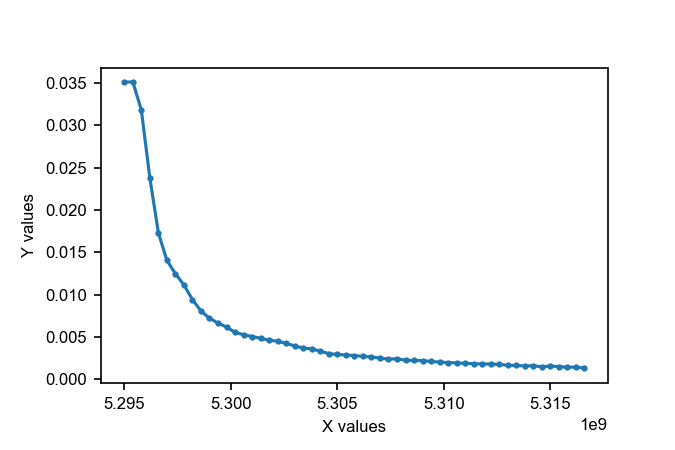

Moving to initial field vector...
Step threshold met, stopping move early.
Move complete.
Optimizing at |B| = 0.3652333637552846...
Step threshold met, stopping move early.
Move complete.
Evaluating at phi = -173.0189425931702, theta = 0.774449633045663
Step threshold met, stopping move early.
Move complete.
Evaluating at phi = -173.0189425931702, theta = 0.7731996330456631
Move complete. (r, phi, theta) = (0.3652333637552846, -173.0189425931702, 0.774449633045663)
Evaluating at phi = -173.0189425931702, theta = 0.775699633045663
Move complete. (r, phi, theta) = (0.3652333637552846, -173.0189425931702, 0.774449633045663)
Found optimum for |B| = 0.3652333637552846 at (-173.0189425931702, 0.774449633045663).
Step threshold met, stopping move early.
Move complete.
Optimizing at |B| = 0.3673563290938957...
Move complete. (r, phi, theta) = (0.3673331730187188, -173.0189425931702, 0.770022331542453)))
Within 4.0 line widths, not re-optimizing yet.
Optimizing at |B| = 0.36947929443250677...
M

KeyboardInterrupt: 

In [115]:
station.RF.power(-30)
xvals = np.arange(5.295e9,5.317e9,0.4e6)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
line = ax.plot(xvals, np.zeros_like(xvals), '.-')[0]

ctl = ss.setup_soft_sweep(xvals, station.hetsrc.frequency, integration_time=30e-3)

# now we wrap the measure function such that it doesn't need arguments anymore
# of course this requires that we have already good constant values for ax and line
measure_trace = partial(measure_and_plot_resonator, ax, line)

# now we just have to call the new function wrapper without arguments


field_opt = FieldOptimizationProblem(station.mgnt, measure_trace, get_resonator_FWHM)



cur_r = station.mgnt.r_measured()
cur_theta = station.mgnt.theta_measured()
cur_phi = station.mgnt.phi_measured()


#with station.TWPA():
optimum, extra = field_opt.optimize_and_ramp_magnitude(
    cur_r, 1000e-3, 300,
    cur_phi, 0, 1,
    cur_theta, 0.0025, 3,
    reoptimization_threshold=4.,
    ramp_rate=3e-3,
    n_steps=7,
    return_extra=True
    )

# # station.TWPA.off()

In [ ]:
plt.figure()
plt.plot(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    zorder=-10
)
plt.scatter(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    c=[field.r for field in extra['history']['optima']]
)
plt.colorbar()

In [ ]:
plt.figure()
plt.plot(extra['history']['objectives'])

# OLD STUFF BELOW - ONLY REFERENCE

In [ ]:
frqs, data = soft_resonator_spec(5.6e9, 5.7e9, 1e6, RF_power=-70)

## Resonator vs time

In [ ]:
start, stop, step = 5.6e9, 5.7e9, 2e6
integration_time = 10e-3
trigger_interval = 1e-3

exp = new_experiment(name='resonator_spec_vs_time', sample_name=qc.config.user.experiment.sample_name)

# set basic RF stuff
station.hetsrc.RF.power(-70)

ctl = station.post_iq_acq
ctl.average_buffers(True)
ctl.demod_frq(station.hetsrc.IF())

SR = station.alazar.sample_rate()
t_buf = trigger_interval - 10e-6
nbufs = int(integration_time // trigger_interval)

acq_size = 2 * integration_time * SR * 1e-6 # in MB
buf_size = 2 * t_buf * SR * 1e-6
print(f'acquisition size: {acq_size} MB; {buf_size} MB/buffer.')  
print(f'acquisition time/buffer: {t_buf*1e6} us; {nbufs} buffers.')

ctl.setup_acquisition(
    samples=int(t_buf * SR // 64 * 64),
    records=1,
    buffers=nbufs,
    allocated_buffers=10,
)

tvals = np.arange(100)
frqs = np.arange(start, stop+step, step)
data = np.zeros((frqs.size, 2), dtype=np.complex64)

m = acquisition_tools.AlazarMeasurement(
    station=station, exp=exp, 
    soft_params=['iteration', station.hetsrc.frequency],
    hard_axes=[
        ('channel', np.array([1,2])),
    ],
    imag=False, real=False, mag=True, phase=True,
)

with m.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for j, it in enumerate(tvals):
        for i, f in enumerate(frqs):
            print(f'Current iteration: {it}. Current frequency: {f*1e-6:.2f} MHz', end='\r')
            station.hetsrc.frequency(f)
            time.sleep(0.01)

            _data = ctl.acquisition()[0,0,0,:]
            data[i,:] = _data
            mag, phase = np.abs(_data), np.angle(_data, deg=True)

            result = m.get_result(_data, (station.hetsrc.frequency, f), ('iteration', it))
            datasaver.add_result(*result)

# Gate response

In [ ]:
station.hetsrc.frequency(5.647e9)
station.hetsrc.RF.power(-70)
SR = station.alazar.sample_rate()
dac = station.ivvi.dac1
dacl = station.ivvi.dac11
dacr = station.ivvi.dac13

station = qc.Station.default
exp = new_experiment(name='gate_response', sample_name=qc.config.user.experiment.sample_name)

ctl = station.post_iq_acq
ctl.average_buffers(True)
ctl.demod_frq(station.hetsrc.IF())

ctl.setup_acquisition(
        samples=int(980e-6 * SR // 64 * 64),
        records=1,
        buffers=10,
        allocated_buffers=10,
    )

gatevals = np.arange(0, 1000, 0.5)

m = acquisition_tools.AlazarMeasurement(
        station=station, exp=exp, 
        soft_params=[dacl],
        hard_axes=[
            ('channel', np.array([1,2])),
        ],
        imag=False, real=False, mag=True, phase=True,
    )

with m.run() as datasaver:
        
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for i, g in enumerate(gatevals):
        print(f'Current gate voltage: {g} mV', end='\r')
        dacl(int(g))
        dacr(int(g))
        dac(int(g))

        _data = ctl.acquisition()[0,0,0,:]
        mag, phase = np.abs(_data), np.angle(_data, deg=True)

        result = m.get_result(_data, (dacl, g))
        datasaver.add_result(*result)

# Qubit spec

# Scribble

In [ ]:
f"{123456:1.3e}"